In [1]:
import numpy as np
from matplotlib import pyplot as plt
from my_utils import *
from sigproc_kit import *

In [2]:
def ion_current(t, Q, P, r0, ra, rb, mu_ion, HV, delay):
    t_ = t - delay
    
    t0 = r0**2 *P *np.log(rb/ra)/(2*mu_ion*HV)
    
    return (t_ > 0) * Q/(2.*np.log(rb/ra)*(t0+t_)  )

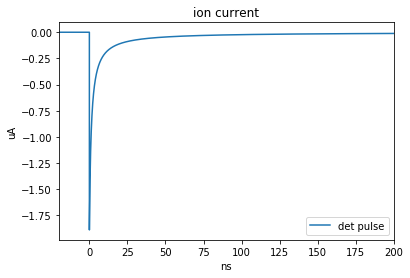

In [3]:
##################################################
##           driftchamber ion current           ##
##################################################


## chamber parameters


# ionization
primary_ions = 1

# gas amplification
G = 1.6e5

# electron charge
e = 1.602e-19


# total charge after gas amplification
Q = -primary_ions * G * e

# gas pressure
P  = 1             # 1 atm = 1 bar

# geometric parameter of idealized proportional counter
# good enough approximation for MDC cell
ra = 10e-6         # 10 um
rb = 2.5e-3        # 2.5 mm
r0 = ra+1e-6       # 1 um over the wire

# argon ion mobility
mu_ion = 1.7*(1e-2)**2 #1.7 cm^2 s^-1 V^-1 atm^-1

# chamber HV (affects only ion drift, not gas gain)
HV = 1600


t = np.linspace(-100e-9,900e-9,100000) # be sure to make not to few steps, if you have a sharp IR

delay = 0e-9 

I = ion_current(t, Q, P, r0, ra, rb, mu_ion, HV, delay)






plt.title("ion current")
plt.plot(t*1e9,I*1e6,label="det pulse")
plt.xlabel("ns")
plt.ylabel("uA")
plt.xlim(-20,200)
plt.legend()
plt.show()

#print("t1 : {:3.3f} ns, tot : {:3.3f} ns".format(t1*1e9,tot*1e9))

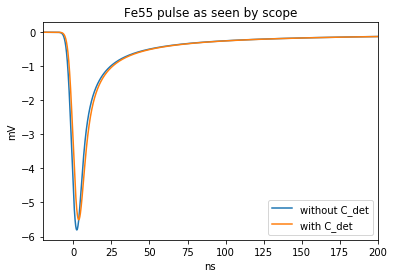

In [4]:
##################################################
##              Fe55 charge cloud               ##
##################################################

primary_ions = 218

# arrival time smearing due to diffusion/drift
sigma_T = 2.7e-9

# gas amplification
G = 1.6e5

e = 1.602e-19

Q = -primary_ions * G * e

I = ion_current(t, Q, P, r0, ra, rb, mu_ion, HV, delay)

# smear current out, due to diffusion
I = fft_gauss_LPF(t,I,sigma=sigma_T)



# detector and cable capacitance (lumped circuit model)
C = 25e-12

# resistive load of the oscilloscope input
R = 50



# calculate time evolution of parallel RC circuit

# time step
dt = t[1]-t[0]


U = np.zeros(len(t))
last_U = 0

# discrete solution of the differential equation
for i in range(len(t)):   
    U[i] = 1/(1/R+C/dt) * ( I[i] + C/dt*last_U) 
    last_U = U[i]



U_direct = I * R

plt.title("Fe55 pulse as seen by scope")
plt.plot(t*1e9,U_direct*1e3,label="without C_det")
plt.plot(t*1e9,U*1e3,label="with C_det")
plt.xlabel("ns")
plt.ylabel("mV")
plt.xlim(-20,200)
plt.legend()
plt.show()
